In [1]:
import yfinance as yf
import pandas as pd
import os
import datetime as dt
import pickle
import numpy as np
import copy
import matplotlib.pyplot as plt

## Some Important Functions

In [2]:
def save_obj(obj, name):
    '''
    Save data as a pickle object.
    '''
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    '''
    Load pickled data.
    '''
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def getHistoricDat(ticks):
    '''
    Download stock data from the Yahoo Finance API.
    '''
    historicDat = {}
    for t in ticks:
        print('{}% done'.format(round(100*(len(historicDat)+1)/len(ticks)), 6))
        stockDat = yf.download(t, 
                               start=insiderDat.TradeDate.min().strftime("%Y-%m-%d"), 
                               end=insiderDat.TradeDate.max().strftime("%Y-%m-%d"), 
                               progress=False)
        historicDat[t] = stockDat
    return historicDat

def validate(date_text):
    '''
    Ensure that all dates have a valid format.
    '''
    try:
        dt.datetime.strptime(date_text, '%Y-%m-%d')
    except ValueError:
        raise ValueError("Incorrect data format, should be YYYY-MM-DD")
        
def getHistoricDat_date(ticks, min_dt, max_dt):
    '''
    Download stock data from the Yahoo Finance API between two dates.
    '''
    validate(min_dt)
    validate(max_dt)
    
    historicDat = {}
    
    for t in ticks:
        if len(historicDat) % 10 == 0:
            print(str(len(historicDat))+'/'+str(len(ticks)) + ' done')
        stockDat = yf.download(t, 
                               start=min_dt, 
                               end=max_dt, 
                               progress=False)
        historicDat[t] = stockDat
    return historicDat

## Clean and Format the Data

In [3]:
insiderDat = pd.read_csv('data/openinsider_June.csv')

insiderDat = insiderDat.rename(columns={insiderDat.columns[1]: "FilingDate", 
                                        insiderDat.columns[2]: "TradeDate", 
                                        insiderDat.columns[4]: "CompanyName", 
                                        insiderDat.columns[5]: "InsiderName", 
                                        insiderDat.columns[7]: "TradeType",
                                        insiderDat.columns[11]: "DeltaOwn"},
                               errors="raise")

# NOTE: I am stripping away the filing date's time; assume we can't buy until opening next day
# https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
insiderDat.FilingDate = [dt.datetime.strptime(str(r), '%Y-%m-%d %H:%M:%S').date() for r in insiderDat.FilingDate]
insiderDat.TradeDate = [dt.datetime.strptime(str(r), '%Y-%m-%d').date() for r in insiderDat.TradeDate]
insiderDat.Ticker = ['NA' if 'Cardinal Ethanol LLC' in t[1] else t[0] 
                     for t in zip(insiderDat.Ticker, insiderDat.CompanyName)]
insiderDat = insiderDat.replace({'Ticker': {'FB': 'META'}})
insiderDat.Price = [float(p.replace(',','').replace('$','')) for p in insiderDat.Price]
insiderDat.Qty = [float(q[1]) if '#' in q[0] else float(q[0].replace(',','')) 
                  for q in zip(insiderDat.Qty, insiderDat.Qty2)]
insiderDat.Owned = [float(o.replace(',','')) for o in insiderDat.Owned]

insiderDat = insiderDat.replace({'DeltaOwn': {'New': '999999'}})
insiderDat = insiderDat.replace({'DeltaOwn': {'>999%': '999999'}})
insiderDat.DeltaOwn = [float(d.replace('%','')) for d in insiderDat.DeltaOwn]
insiderDat = insiderDat.replace({'DeltaOwn': {'999999': 10*max(insiderDat.DeltaOwn)}})
insiderDat.Value = [float(v[1]) if '#' in v[0] else float(v[0].replace(',','').replace('$','')) 
                    for v in zip(insiderDat.Value, insiderDat.Value2)]

insiderDat = insiderDat.sort_values(by='FilingDate').reset_index().drop('index', axis=1)

insiderDat.head()

,X,FilingDate,TradeDate,Ticker,CompanyName,InsiderName,Title,TradeType,Price,Qty,Owned,DeltaOwn,Value,Qty2,Value2
0,NaN,2021-06-01,2021-06-01,CARE,"Carter Bankshares, Inc.",Van Dyke Litz H,CEO,P - Purchase,15.41,129.0,18557.0,1.0,1988.0,129.0,1988.0
1,M,2021-06-01,2021-05-27,PANL,Pangaea Logistics Solutions Ltd.,"Pangaea One Acquisition Holdings Xiv, LLC",10%,S - Sale,4.21,-184466.0,6788742.0,-3.0,-775965.0,NaN,NaN
2,M,2021-06-01,2021-05-27,TALO,Talos Energy Inc.,"Apollo Management Holdings Gp, LLC",10%,S - Sale,14.10,-81942.0,18808537.0,0.0,-1155620.0,NaN,NaN
3,A,2021-06-01,2019-07-18,CLXT,"Calyxt, Inc.",Dumont Philippe,Dir,S - Sale,10.00,-706.0,16354.0,-4.0,-7060.0,NaN,NaN
4,M,2021-06-01,2021-05-27,FLUX,"Flux Power Holdings, Inc.",Johnson Michael,"Dir, 10%",S - Sale,10.55,-38738.0,4584558.0,-1.0,-408564.0,NaN,NaN


In [4]:
allTickers = insiderDat.Ticker.unique()
print('There are ' + str(len(allTickers)) + ' tickers')

There are 1795 tickers


In [5]:
historicDat = load_obj('historicDat')
#getHistoricDat_date(allTickers, '2021-06-01', '2021-12-01')
#save_obj(historicDat, 'historicDat')
#

In [6]:
historicDat['IBP']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-06-01,119.379997,120.970001,118.169998,120.449997,117.257050,303100
2021-06-02,119.849998,119.849998,117.129997,117.639999,114.521530,300600
2021-06-03,116.800003,117.800003,114.470001,117.220001,114.112679,280000
2021-06-04,118.669998,119.900002,115.779999,119.709999,116.536667,137400
2021-06-07,120.059998,120.489998,118.620003,119.300003,116.137543,125400
...,...,...,...,...,...,...
2021-11-23,138.679993,140.070007,136.690002,139.410004,136.401169,120700
2021-11-24,137.919998,138.929993,136.820007,137.779999,134.806351,127400
2021-11-26,133.399994,135.429993,130.509995,133.169998,130.295853,141900


In [7]:
SP500Dat = load_obj('SP500Dat')
#getHistoricDat_date(['SPY'], '2021-06-01', '2021-11-30')
#save_obj(SP500Dat, 'SP500Dat')

In [8]:
print('This is a ticker that no longer exists, so we want to ignore it:')
historicDat['TREC']

This is a ticker that no longer exists, so we want to ignore it:


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [9]:
ghostTickers = set()

for tick in allTickers:
    if historicDat[tick].empty:
        ghostTickers.add(tick)

insiderDat = insiderDat[insiderDat.Ticker.isin(ghostTickers)==False]
insiderDat = insiderDat.drop(['X', 'Qty2', 'Value2'], axis=1).reset_index()
insiderDat = insiderDat.drop(['index'], axis=1)

allUniqueTickers = insiderDat.Ticker.unique()
print('There are ' + str(len(allUniqueTickers)) + ' filtered tickers')

There are 1684 filtered tickers


In [10]:
newTickers = set()
for tick in allUniqueTickers:
    if historicDat[tick].index[0] > dt.datetime.strptime('2021-06-01', '%Y-%m-%d'):
        newTickers.add(tick)
        
print(f'There are {len(newTickers)} tickers that were listed on an exchange after June 1st')

There are 29 tickers that were listed on an exchange after June 1st


29 isn't all that many, so let's get rid of them because they cause problems in the code below.

In [11]:
insiderDat = insiderDat.loc[insiderDat['Ticker'].isin(newTickers) == False]

In [12]:
insiderDat.to_csv('data/insiderDat_June_clean.csv', index=False)
insiderDat.head()

,FilingDate,TradeDate,Ticker,CompanyName,InsiderName,Title,TradeType,Price,Qty,Owned,DeltaOwn,Value
0,2021-06-01,2021-06-01,CARE,"Carter Bankshares, Inc.",Van Dyke Litz H,CEO,P - Purchase,15.41,129.0,18557.0,1.0,1988.0
1,2021-06-01,2021-05-27,PANL,Pangaea Logistics Solutions Ltd.,"Pangaea One Acquisition Holdings Xiv, LLC",10%,S - Sale,4.21,-184466.0,6788742.0,-3.0,-775965.0
2,2021-06-01,2021-05-27,TALO,Talos Energy Inc.,"Apollo Management Holdings Gp, LLC",10%,S - Sale,14.10,-81942.0,18808537.0,0.0,-1155620.0
3,2021-06-01,2019-07-18,CLXT,"Calyxt, Inc.",Dumont Philippe,Dir,S - Sale,10.00,-706.0,16354.0,-4.0,-7060.0
4,2021-06-01,2021-05-27,FLUX,"Flux Power Holdings, Inc.",Johnson Michael,"Dir, 10%",S - Sale,10.55,-38738.0,4584558.0,-1.0,-408564.0


In [13]:
def returnDataOnDate(historicDat, tick, startDate, delta=0, dataName='Close', searchDirection=1):
    '''
    Given a start date, return tick's data associated with 'dataName', 'delta' days later. In the event that the 
    stock market was not open on this future date, function returns the nearest viable date in the 
    direction of 'searchDirection', looking forward or backward one day at a time.
    
    IN:
        -historicDat (dict)
        -tick (str)
        -startDate (str): %Y-%m-%d
        -delta (int)
        -dataName (str): 'Open', 'Close', 'Volume', etc
        -searchDirection (int): either +1 or -1
    OUT:
        -price (float)
        -futureDate (date object)
    '''
    
    futureDate = str(dt.date.isoformat(dt.datetime.strptime(startDate, '%Y-%m-%d') 
                                           + dt.timedelta(days=delta)))
    
    e = 'KeyError'
    while e == 'KeyError':
        try:
            price = historicDat[tick].loc[futureDate][dataName]
            e = 'No Error'

        except KeyError:
            futureDate = str(dt.date.isoformat(dt.datetime.strptime(futureDate, '%Y-%m-%d') 
                                               + dt.timedelta(days=searchDirection)))
            if dt.datetime.strptime(futureDate, '%Y-%m-%d') < dt.datetime.strptime('2021-06-01', '%Y-%m-%d'):
                raise ValueError('Out-of-bounds date caused by ' + tick + ' on ' + startDate)
            
    return price, dt.datetime.strptime(futureDate, '%Y-%m-%d').date()

In [14]:
def returnPriceDiff(insiderDat, historicDat, SP500Dat, delta, priceTime):
    '''
    Returns difference between price at 'priceTime' on the initial filing date and price at 'priceTime',
    'delta' days later for each ticker in 'historicDat'.
    
    IN:
        -insiderDat (pd.DataFrame)
        -historicDat (dict): maps ticker name (str) to ticker data (pd.DataFrame)
        -SP500Dat (dict): maps ticker name (str) to ticker data (pd.DataFrame)
        -delta (int)
        -priceTime (str): 'Open', 'Close'
    OUT:
        -closingDiff (dict): maps trade (str) to % price difference for ticker and S&P500 (float, float)
    '''
    
    closingDiff = {}
    
    for trade in insiderDat.iterrows():
        tradeNum = trade[0]
        tick = trade[1]['Ticker']
        
        startDate = str(trade[1]['FilingDate'])
        
        startPrice, _ = returnDataOnDate(historicDat, tick, startDate, dataName=priceTime, searchDirection=-1)
        futurePrice, _ = returnDataOnDate(historicDat, tick, startDate, dataName=priceTime, delta=delta)
        startPrice_SP500, _ = returnDataOnDate(SP500Dat, 'SPY', startDate, dataName=priceTime, searchDirection=-1)
        futurePrice_SP500, _ = returnDataOnDate(SP500Dat, 'SPY', startDate, dataName=priceTime, delta=delta)
        
        closingDiff[tick + str(tradeNum)] = (100*(futurePrice - startPrice) / startPrice, 
                                             100*(futurePrice_SP500 - startPrice_SP500) / startPrice_SP500)

    return closingDiff

In [15]:
EODayPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=1, priceTime='Close')

EOWeekPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=7, priceTime='Close')

EOMonthPrice = returnPriceDiff(insiderDat, historicDat, SP500Dat, delta=30, priceTime='Close')

In [18]:
print('(% change in ticker price, % change in S&P500):')
EOMonthPrice['CARE0']

(% change in ticker price, % change in S&P500):


(-18.287187388409205, 2.563914243041266)

In [19]:
def createDifferencePlots(diffDat, delta, thresh):
    tickPrices = [val[0] for val in diffDat.values()]
    SP500Prices = [val[1] for val in diffDat.values()]
    
    fig, ax = plt.subplots(1, 1)
    ax.plot(diffDat.keys(), tickPrices, '.b', markersize=8)
    ax.plot(diffDat.keys(), SP500Prices, '--r', label='S&P500')
    ax.set_xticklabels([])
    
    for key in diffDat.keys():
        if abs(diffDat[key][0]) > thresh:
            ax.annotate(key, (key, diffDat[key][0]))
    
    plt.xticks([])
    plt.xlabel(f'({len(diffDat)} Trades)')
    plt.ylabel(f'% difference in price after {delta} days')
    #plt.yscale('symlog')
    plt.title(f'Stock price percentage difference after insider buy: {delta} days later')
    plt.legend()
    plt.show()
    
    #mplcursors.cursor(multiple = True).connect(
    #    "add", lambda sel: sel.annotation.set_text(diffDat.keys()[sel.target.index]))

    diffDat_filtered = [v for v in diffDat.values() if v is not None]
    print(f'The mean increase is {np.mean(diffDat_filtered)}%.')
    print(f'The standard deviation is {np.std(diffDat_filtered)}%.')
               
    return None

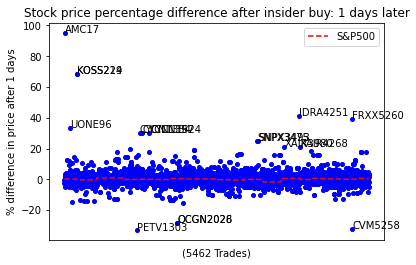

The mean increase is 0.1681267019184525%.
The standard deviation is 2.8488228585993363%.


In [20]:
createDifferencePlots(EODayPrice, delta=1, thresh=20)

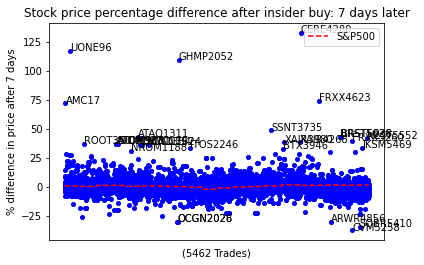

The mean increase is 0.6039100086929385%.
The standard deviation is 5.2569275427104225%.


In [21]:
createDifferencePlots(EOWeekPrice, delta=7, thresh=30)

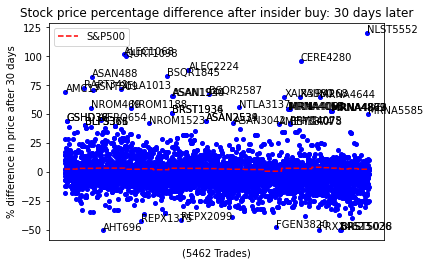

The mean increase is 0.4828866530614808%.
The standard deviation is 9.256202242127106%.


In [22]:
createDifferencePlots(EOMonthPrice, delta=30, thresh=40)

Let's look into the price trends of only those tickers that experienced qualitatively-outlying changes; say, +/- 20% after one day, +/- 30% after one week, or +/- 40% after one month.

In [23]:
#trade.translate({ord(ch): None for ch in '0123456789'})

days2lookForward = 30

outlierClosings_up = [np.zeros((1,days2lookForward))]*3
outlierClosings_down = [np.zeros((1,days2lookForward))]*3

for trade in insiderDat.iterrows():
    tradeNum = trade[0]
    tick = trade[1]['Ticker']
    tradeName = tick + str(tradeNum)
    
    fileDate = str(trade[1]['FilingDate'])

    # if the trade's ticker changes by a sufficient amount, store its daily closing for the next 
    # 'days2lookForward' days
    increaseThresh = [20, 30, 40]
    EO_Prices = [EODayPrice, EOWeekPrice, EOMonthPrice]
    
    for i in range(3):
        if abs(EO_Prices[i][tradeName][0]) > increaseThresh[i]:
            newCol = np.zeros((1,days2lookForward))
            startingPrice, _ = returnDataOnDate(historicDat, tick, fileDate, delta=0)
            for d in range(days2lookForward):
                closingPrice, _ = returnDataOnDate(historicDat, tick, fileDate, delta=d)
                newCol[0,d] = 100*(closingPrice-startingPrice)/startingPrice

            if EO_Prices[i][tradeName][0] > increaseThresh[i]:
                outlierClosings_up[i] = np.append(outlierClosings_up[i], newCol, axis=0)
            else:
                outlierClosings_down[i] = np.append(outlierClosings_down[i], newCol, axis=0)

In [24]:
def createOutlyingDifferencePlots(outlierClosings_up, outlierClosings_down):
    fig, ax = plt.subplots(1, 1)
    for row in outlierClosings_up:
        ax.plot(list(range(outlierClosings_up.shape[1])), row, '-b', markersize=8)
    for row in outlierClosings_down:
        ax.plot(list(range(outlierClosings_down.shape[1])), row, '-r', markersize=8)
    #ax.legend()
    #ax.set_xticklabels([])
    
    #plt.xticks([])
    plt.xlabel(f'(Days after Trade)')
    plt.ylabel(f'% difference from original price')
    #plt.legend('initial increase', 'initial decrease')
    #plt.yscale('symlog')
    plt.title(f'Outlying stock price percentage differences after insider trade')
    plt.show()
    
    return None

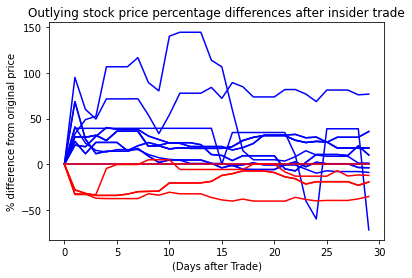

30-day closing prices for stocks that rose (blue) or fell (red) by at least 20% within ONE day of the filing date.


In [26]:
createOutlyingDifferencePlots(outlierClosings_up[0], outlierClosings_down[0])
print('30-day closing prices for stocks that rose (blue) or fell (red) by at least 20% within ONE day \
of the filing date.')

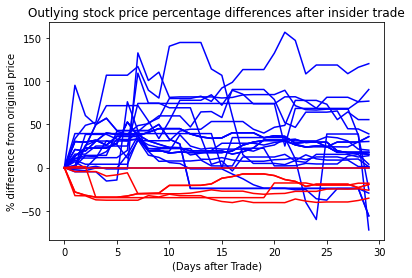

30-day closing prices for stocks that rose (blue) or fell (red) by at least 30% within SEVEN days of the filing date.


In [27]:
createOutlyingDifferencePlots(outlierClosings_up[1], outlierClosings_down[1])
print('30-day closing prices for stocks that rose (blue) or fell (red) by at least 30% within SEVEN days \
of the filing date.')

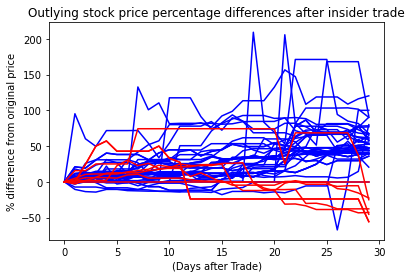

30-day closing prices for stocks that rose (blue) or fell (red) by at least 40% within THIRTY days of the filing date.


In [28]:
createOutlyingDifferencePlots(outlierClosings_up[2], outlierClosings_down[2])
print('30-day closing prices for stocks that rose (blue) or fell (red) by at least 40% within THIRTY days \
of the filing date.')

It appears that, for the most part, outlying upward price jumps tend to occur within at most a few days of the filing date, although this is often more delayed for prices that are outlying a month after the filing.

Outlying downward price jumps seem to hold or continue downwards. However, we see a few examples of volatile stocks that significantly gained initially before eventually plummeting at the end of the month -- we want to capture that intial upward behavior and then sell!

Based on these charts, it seems reasonable to work with the following prediction metric:
**What is the predicted maximum percentage gain in the next X days, where X is at most, say, 10?**

Let's choose X=7 for now, and we will also look back 1 day for things like volume and same-ticker trades.

In [31]:
DAYS_TO_LOOK_FORWARD = 7
DAYS_TO_LOOK_BACK = 1

Now we should explore a few other things of interest, namely
- the number of same-ticker trades filed in the previous few days,
- the change in volume over the previous few days.

In [37]:
def returnVolumeAndPriceChange(historicDat, tick, fileDate, daysToLookForward, daysToLookBack):
    currentVol, dateUsed = returnDataOnDate(historicDat, tick, dt.date.isoformat(fileDate), 
                                            dataName='Volume', searchDirection=-1)
    
    previousVol, prevDateUsed = returnDataOnDate(historicDat, tick, 
                                      dt.date.isoformat(dateUsed-dt.timedelta(days=daysToLookBack)), 
                                      dataName='Volume', searchDirection=-1)
    if previousVol == 0 and currentVol == 0:
        percentChangeVol = 0
    elif previousVol == 0:
        percentChangeVol = 9999
    else:          
        percentChangeVol = 100*(currentVol-previousVol) / previousVol
    
    
    currentPrice = historicDat[tick].loc[dt.date.isoformat(dateUsed)]['Close']
    
    mostSigPrice = currentPrice
    mostSigPriceDiff = 0
    for i in range(daysToLookForward):
        tempPrice, _ = returnDataOnDate(historicDat, tick, dt.date.isoformat(dateUsed), delta=i)
        tempDiff = abs(tempPrice-currentPrice)
        if tempDiff > mostSigPriceDiff:
            mostSigPrice = tempPrice
            mostSigPriceDiff = tempDiff
            
    percentChangePrice = 100*(mostSigPrice-currentPrice) / currentPrice
    
    return percentChangeVol, percentChangePrice
        

def createVolumePriceScatters(volPriceDat):
    fig, ax = plt.subplots(1, 1)
    ax.plot([val[0] for val in volPriceDat], [val[1] for val in volPriceDat], '.b', markersize=8)
    
    plt.xlabel(f'% Change in Volume in Previous {DAYS_TO_LOOK_BACK} Days')
    plt.ylabel(f'% Change in Closing Price in Next {DAYS_TO_LOOK_FORWARD} Days')
    plt.xscale('symlog')
    plt.title(f'Price Change vs Volume Change')
    plt.show()
               
    return None

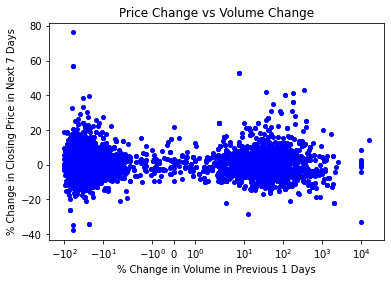

In [38]:
startDate = dt.datetime.strptime('2021-06-01', '%Y-%m-%d').date()

volPriceDat = []
for trade in insiderDat.iterrows():
    tick = trade[1]['Ticker']
    fileDate = trade[1]['FilingDate']
    
    # skip the first DAYS_TO_LOOK_BACK days so we have data to look back at
    if (fileDate - dt.timedelta(days=DAYS_TO_LOOK_BACK)) < startDate:
        continue
    
    volPriceDat.append(returnVolumeAndPriceChange(historicDat, tick, fileDate, 
                                                  DAYS_TO_LOOK_FORWARD, DAYS_TO_LOOK_BACK))

createVolumePriceScatters(volPriceDat)

The volume losers and gainers are clearly split into two camps on the semilog plot.

Notice that most large price changes (at least +/- 20%) are associated with larger volume changes (at least +/- 10%). Therefore, that is where we will choose to place our categorical boundaries: dV < -10%, -10% < dV < 0%, 0% < dV < 10%, and dV > 10%.

Finally, let's take a closer look at some of the bigger price movements relative to when a trade was made.

In [39]:
insiderDat.Ticker.value_counts()

CONN    78
ZI      51
CRC     45
ZIP     41
CVNA    33
        ..
XXII     1
CPT      1
TARA     1
RIOT     1
CALX     1
Name: Ticker, Length: 1655, dtype: int64

In [77]:
def plotPriceWithTrades(historicDat, tick, insiderDat):
    insiderDat.TradeDate = [np.datetime64(td) for td in insiderDat.TradeDate]
    insiderDat.FilingDate = [np.datetime64(td) for td in insiderDat.FilingDate]
    groups = insiderDat.groupby('TradeType')
    
    historicDat_Jun = pd.DataFrame(columns=historicDat[tick].columns, index=historicDat[tick].index)
    historicDat_Jun = historicDat_Jun.astype(float)
    for d in pd.date_range(start='2021-06-01', end='2021-06-30'):
        try:
            historicDat_Jun.loc[d] = historicDat[tick].loc[d]
        except KeyError:
            pass
    
    historicDat_Jun = historicDat_Jun.dropna()
    
    fin_av = [(historicDat_Jun.High[i] + historicDat_Jun.Low[i])/2 for i in range(len(historicDat_Jun))]

    fig, ax = plt.subplots()
    ax.plot(historicDat_Jun.index, fin_av)
    ax.fill_between(historicDat_Jun.index, historicDat_Jun.Low, historicDat_Jun.High, color='b', alpha=.1)
    for name, group in groups:
        ax.plot(group.TradeDate, group.Price, marker='o', linestyle='', label=name)
        ax.plot(group.FilingDate, group.Price, marker='o', linestyle='', label=name+' (filed)', color='r')
    ax.legend()
    
    plt.xticks(rotation=45)
    plt.title(tick + ' price in June')

In [41]:
import warnings
warnings.filterwarnings('ignore')

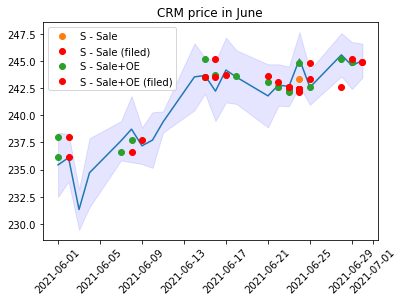

In [78]:
plotPriceWithTrades(historicDat, 'CRM', insiderDat[insiderDat.Ticker == 'CRM'])

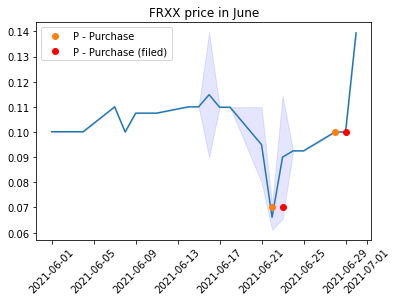

In [79]:
plotPriceWithTrades(historicDat, 'FRXX', insiderDat[insiderDat.Ticker == 'FRXX'])

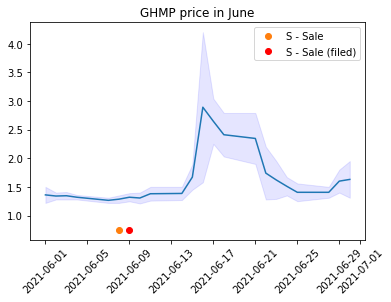

In [80]:
plotPriceWithTrades(historicDat, 'GHMP', insiderDat[insiderDat.Ticker == 'GHMP'])

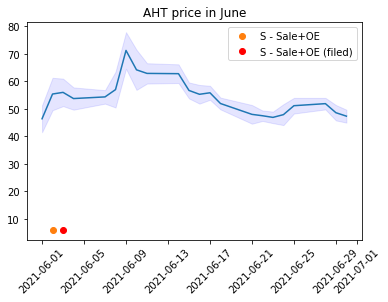

In [81]:
plotPriceWithTrades(historicDat, 'AHT', insiderDat[insiderDat.Ticker == 'AHT'])